### Import libraries

In [58]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

print(tf.config.list_physical_devices())



2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Set seed for reproducibility

In [59]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

 # Load the training dataset

In [60]:
path = os.getcwd()
# Load the .npy file
X = np.load(path+r'\training\x_train.npy')
y = np.load(path+r'\training\y_train.npy')

print(X.shape, X.dtype, sep=", ")   
print(y.shape, y.dtype, sep=", ") 

(2429, 36, 6), float64
(2429,), int32


Plotting the classes distributions

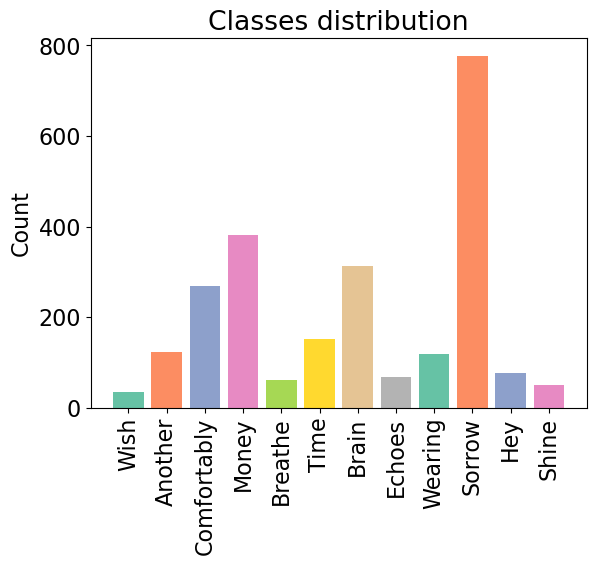

In [61]:
# Map classes STRINGS to integers
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

#vertical bar plot of the classes distribution in y
plt.title('Classes distribution')
plt.bar(label_mapping.keys(), np.bincount(y), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()


 Train-test split

In [62]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print("training set : ", X_train.shape)
print("test set: ", X_test.shape)

training set :  (1943, 36, 6)
test set:  (486, 36, 6)


Class weights computation

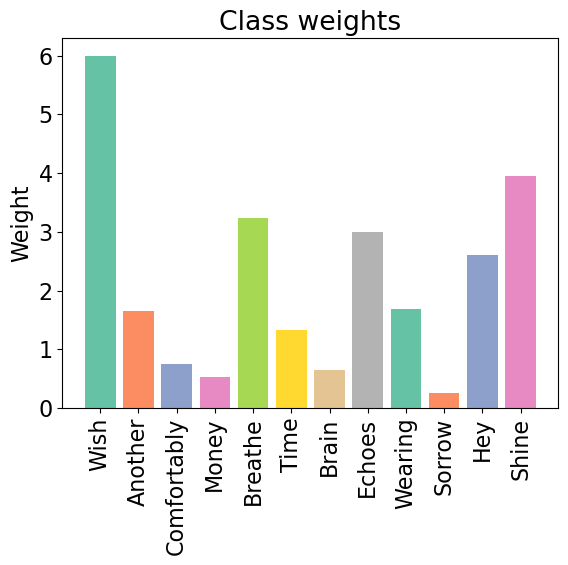

In [63]:
# Compute the class weights in order to balance loss during training
labels = np.unique(np.fromiter([t for t in y_train], np.int32))
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_train)))

# plot class weights with respect to the labels
plt.title('Class weights')
plt.bar(label_mapping.keys(), class_weights.values(), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Weight')
plt.show()


Application of Min Max Scaler to the dataset

In [64]:
features_num = X_train.shape[2]
print("features: ", features_num)

scalers = {}
for i in range(features_num):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(features_num):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

features:  6


Categorical labels for the training and test data

In [65]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(1943, 12)
(486, 12)


## Build the models

Hyperparameters

In [66]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 64
epochs = 200


Plot history of the training and the learning rate schedule

In [67]:
def plot_history(history):
	best_epoch = np.argmax(history['val_accuracy'])
	plt.figure(figsize=(17,4))
	plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
	plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
	plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
	plt.title('Categorical Crossentropy')
	plt.legend()
	plt.grid(alpha=.3)
	plt.show()

	plt.figure(figsize=(17,4))
	plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
	plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
	plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
	plt.title('Accuracy')
	plt.legend()
	plt.grid(alpha=.3)
	plt.show()

	plt.figure(figsize=(17,4))
	plt.title('Learning Rate Schedule')
	plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
	plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
	plt.legend()
	plt.grid(alpha=.3)
	plt.show()

Plot confusion matrix, F1 scores and displays model accuracy

In [68]:
def plot_statistics(predictions):	
	# Compute the confusion matrix
	cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

	# Compute the classification metrics
	accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
	precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
	recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
	f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
	print('Accuracy:',accuracy.round(4))
	print('Precision:',precision.round(4))
	print('Recall:',recall.round(4))
	print('F1:',f1.round(4))

	# Plot the confusion matrix
	plt.figure(figsize=(7, 6))
	plt.title('Confusion matrix')
	sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()), annot=True, fmt="d")
    plt.xlabel('True labels')
	plt.ylabel('Predicted labels')
	plt.show()

	# horizontal bar plot of the f1 scores for each class
	plt.figure(figsize=(6,4))
	plt.barh(y=list(label_mapping.keys()), width=f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average=None))
	plt.title('F1 scores')
	plt.show()

#### Vanilla Long Short Term Memory (LSTM) Neural Network

In [69]:
def build_LSTM_classifier(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # in the LSTM layers: 
    # return_sequences=True -> output = batch_size * timestamps * features
    # return_sequences=False -> output = batch_size * 1 (just last timestamp) * features

    # Feature extractor
    lstm = tfkl.LSTM(512, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(512, return_sequences=True)(lstm)
    lstm = tfkl.LSTM(256, return_sequences=False)(lstm)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)

    # Classifier
    dense = tfkl.Dense(256, activation='relu')(dropout)
    dense = tfkl.Dense(256, activation='relu')(dense)
    dense = tfkl.Dense(128, activation='relu')(dense)
    dropout = tfkl.Dropout(.4, seed=seed)(dense)
    output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model1')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(3e-4), metrics='accuracy')

    # Return the model
    return model

In [70]:
model = build_LSTM_classifier(input_shape)
model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_12 (LSTM)              (None, 36, 512)           1062912   
                                                                 
 lstm_13 (LSTM)              (None, 36, 512)           2099200   
                                                                 
 lstm_14 (LSTM)              (None, 256)               787456    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dense_19 (Dense)            (None, 256)               65792

In [71]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=11, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.75, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 9s 121ms/step - loss: 2.3469 - accuracy: 0.1112 - val_loss: 2.1971 - val_accuracy: 0.1605 - lr: 3.0000e-04
Epoch 2/200
31/31 [==============================] - 2s 79ms/step - loss: 1.9358 - accuracy: 0.2002 - val_loss: 2.0319 - val_accuracy: 0.1728 - lr: 3.0000e-04
Epoch 3/200
31/31 [==============================] - 2s 79ms/step - loss: 1.7038 - accuracy: 0.2692 - val_loss: 1.7632 - val_accuracy: 0.2819 - lr: 3.0000e-04
Epoch 4/200
31/31 [==============================] - 2s 79ms/step - loss: 1.4112 - accuracy: 0.3520 - val_loss: 1.7106 - val_accuracy: 0.3107 - lr: 3.0000e-04
Epoch 5/200
31/31 [==============================] - 2s 79ms/step - loss: 1.2707 - accuracy: 0.4117 - val_loss: 1.7029 - val_accuracy: 0.3457 - lr: 3.0000e-04
Epoch 6/200
31/31 [==============================] - 2s 79ms/step - loss: 1.1791 - accuracy: 0.4261 - val_loss: 1.4771 - val_accuracy: 0.3560 - lr: 3.0000e-04
Epoch 7/200
31/31 [==========================

LSTM model evaluation

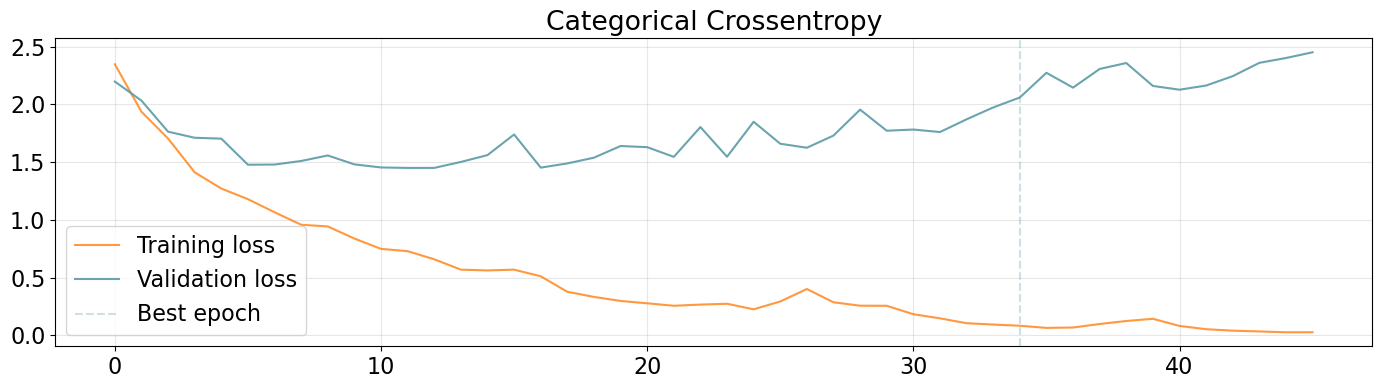

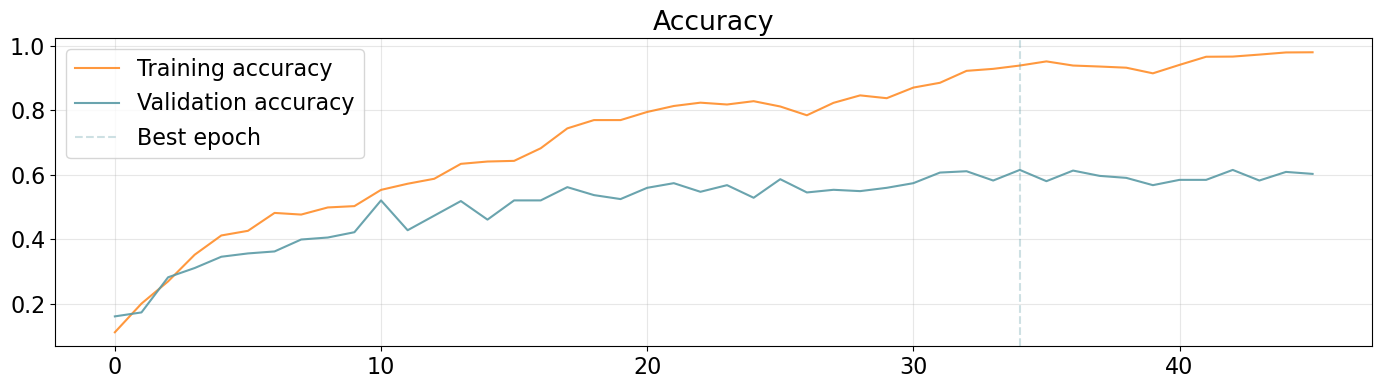

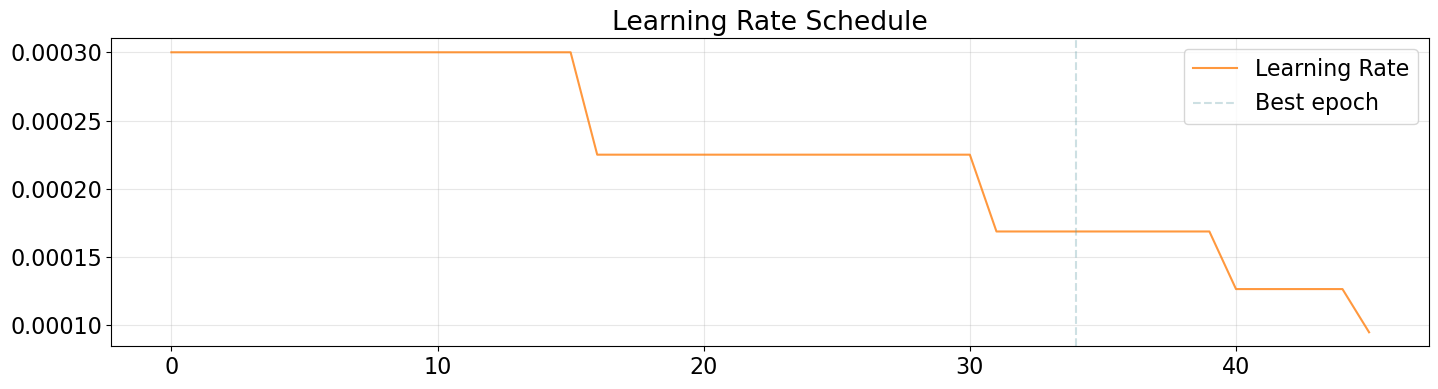

16/16 [==============================] - 1s 22ms/step
Accuracy: 0.6152
Precision: 0.5635
Recall: 0.5261
F1: 0.5381


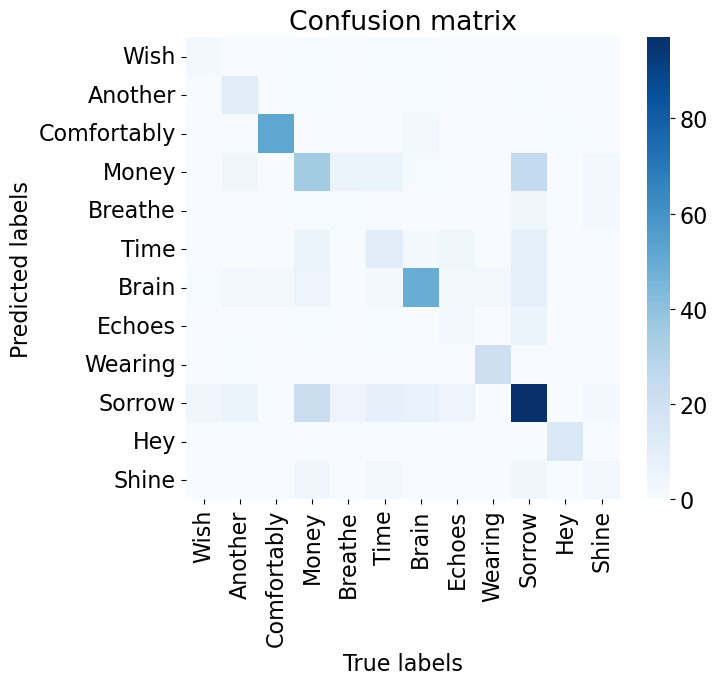

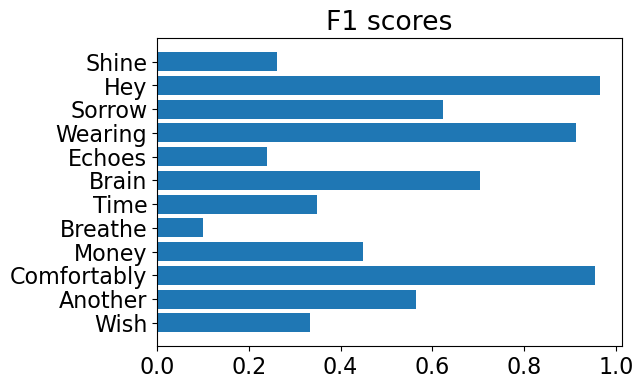

In [72]:
plot_history(history)

# Predict the test set with the LSTM
predictions = model.predict(X_test)

plot_statistics(predictions)

Save model with the validation accuracy in the name

In [73]:
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

model_name = "model_vanilla_" + str(accuracy.round(5))
model.save(model_name)

INFO:tensorflow:Assets written to: model_vanilla_0.61523\assets


INFO:tensorflow:Assets written to: model_vanilla_0.61523\assets


#### Bidirectional Long Short Term Memory (BiLSTM) Neural Network

In [74]:
def build_BiLSTM_classifier(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(512, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(384, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=False))(bilstm)
    dropout = tfkl.Dropout(.4, seed=seed)(bilstm)

    # Classifier
    dense = tfkl.Dense(256, activation='relu')(dropout)
    dense = tfkl.Dense(128, activation='relu')(dense)
    output_layer = tfkl.Dense(classes, activation='softmax')(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model2')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(3e-4), metrics='accuracy')

    # Return the model
    return model

In [75]:
model = build_BiLSTM_classifier(input_shape)
model.summary() #note double number of parameters (this is because we have a bidirectional lstm)

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 36, 1024)         2125824   
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 36, 768)          4328448   
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 512)              2099200   
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                            

In [76]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=11, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.75, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 17s 259ms/step - loss: 2.1310 - accuracy: 0.2229 - val_loss: 1.8195 - val_accuracy: 0.2654 - lr: 3.0000e-04
Epoch 2/200
31/31 [==============================] - 5s 162ms/step - loss: 1.5371 - accuracy: 0.3181 - val_loss: 1.7214 - val_accuracy: 0.2901 - lr: 3.0000e-04
Epoch 3/200
31/31 [==============================] - 5s 163ms/step - loss: 1.1664 - accuracy: 0.4375 - val_loss: 1.4779 - val_accuracy: 0.3930 - lr: 3.0000e-04
Epoch 4/200
31/31 [==============================] - 5s 165ms/step - loss: 1.0181 - accuracy: 0.4658 - val_loss: 1.3763 - val_accuracy: 0.4362 - lr: 3.0000e-04
Epoch 5/200
31/31 [==============================] - 5s 172ms/step - loss: 0.8405 - accuracy: 0.5265 - val_loss: 1.4106 - val_accuracy: 0.4321 - lr: 3.0000e-04
Epoch 6/200
31/31 [==============================] - 6s 179ms/step - loss: 0.7424 - accuracy: 0.5630 - val_loss: 1.3037 - val_accuracy: 0.4877 - lr: 3.0000e-04
Epoch 7/200
31/31 [====================

Bidirectional LSTM model evaluation

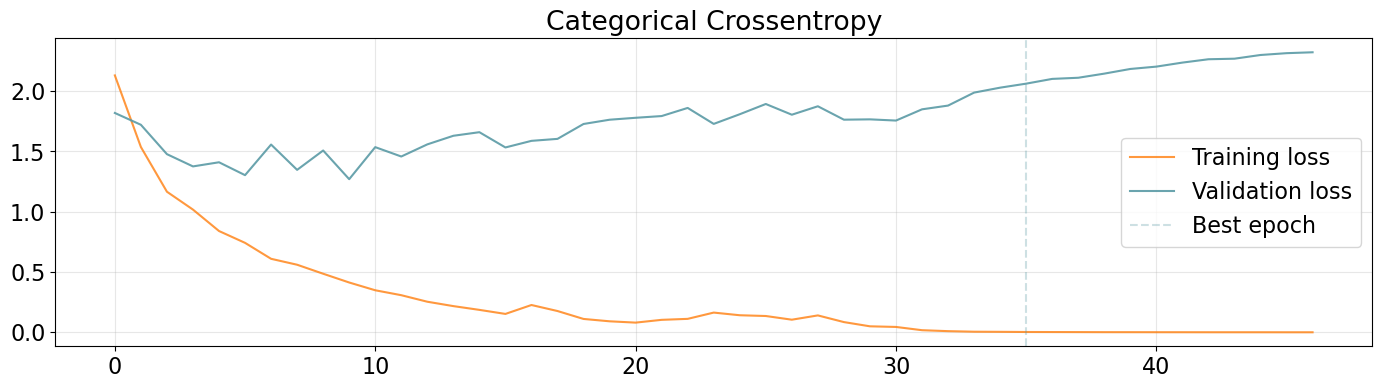

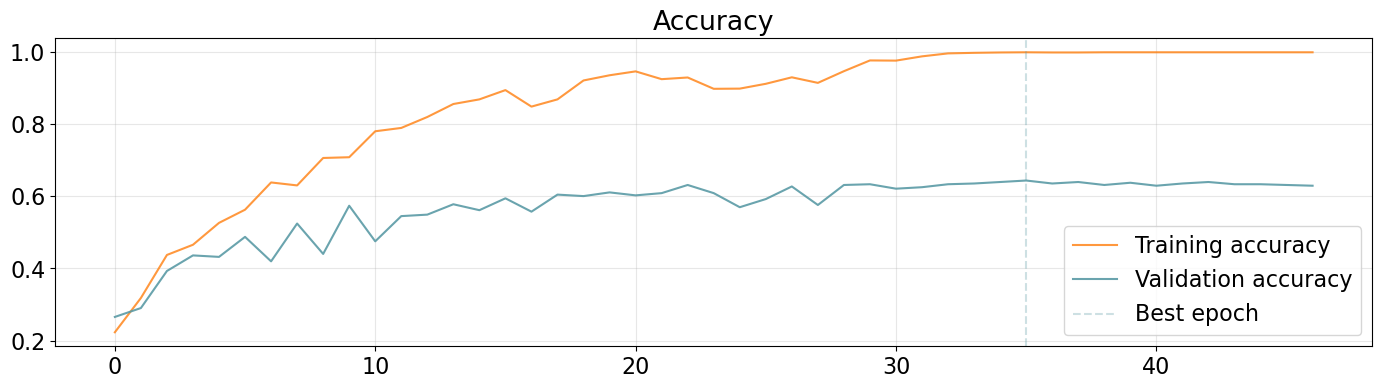

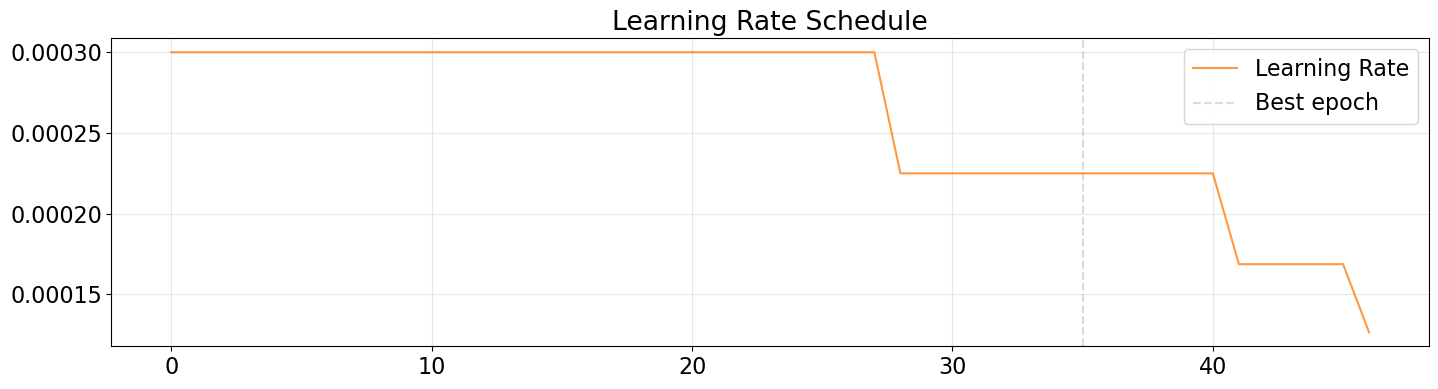

16/16 [==============================] - 3s 47ms/step
Accuracy: 0.644
Precision: 0.5833
Recall: 0.5498
F1: 0.5625


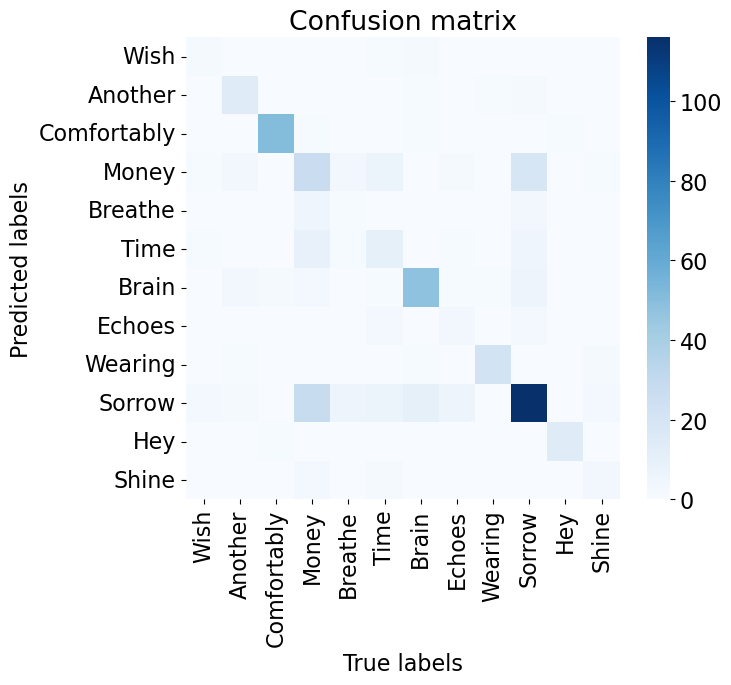

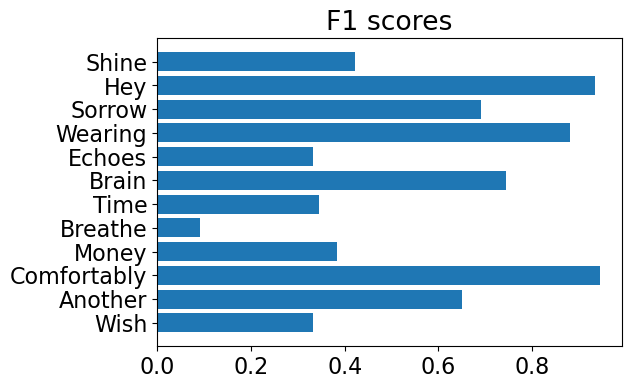

In [77]:
plot_history(history)

# Predict the test set with the LSTM
predictions = model.predict(X_test)

plot_statistics(predictions)

Save bidirectional lstm model with accuracy in the name

In [78]:
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

model_name = "model_bilstm_" + str(accuracy.round(5))
model.save(model_name)

INFO:tensorflow:Assets written to: model_bilstm_0.64403\assets


INFO:tensorflow:Assets written to: model_bilstm_0.64403\assets


#### 1D Convolutional Neural Network

In [79]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [80]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 36, 128)           2432      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 18, 128)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 18, 128)           49280     
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_11 (Dropout)        (None, 128)               0     

In [81]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=11, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.75, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 2s 24ms/step - loss: 31.3682 - accuracy: 0.0638 - val_loss: 10.9436 - val_accuracy: 0.0391 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 14ms/step - loss: 17.8698 - accuracy: 0.0767 - val_loss: 6.6387 - val_accuracy: 0.0535 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 15ms/step - loss: 9.7355 - accuracy: 0.0715 - val_loss: 9.4851 - val_accuracy: 0.0453 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 1s 16ms/step - loss: 11.1529 - accuracy: 0.0823 - val_loss: 4.6774 - val_accuracy: 0.0782 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 15ms/step - loss: 10.6395 - accuracy: 0.0690 - val_loss: 5.6360 - val_accuracy: 0.0535 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 1s 18ms/step - loss: 5.5152 - accuracy: 0.0865 - val_loss: 5.0185 - val_accuracy: 0.0761 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 12ms/step

Convolution in 1D model evaluation

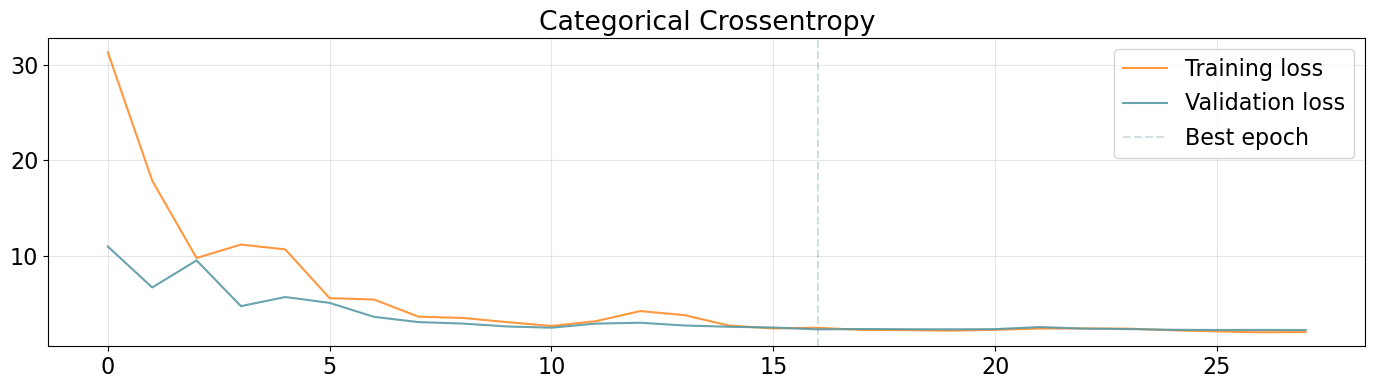

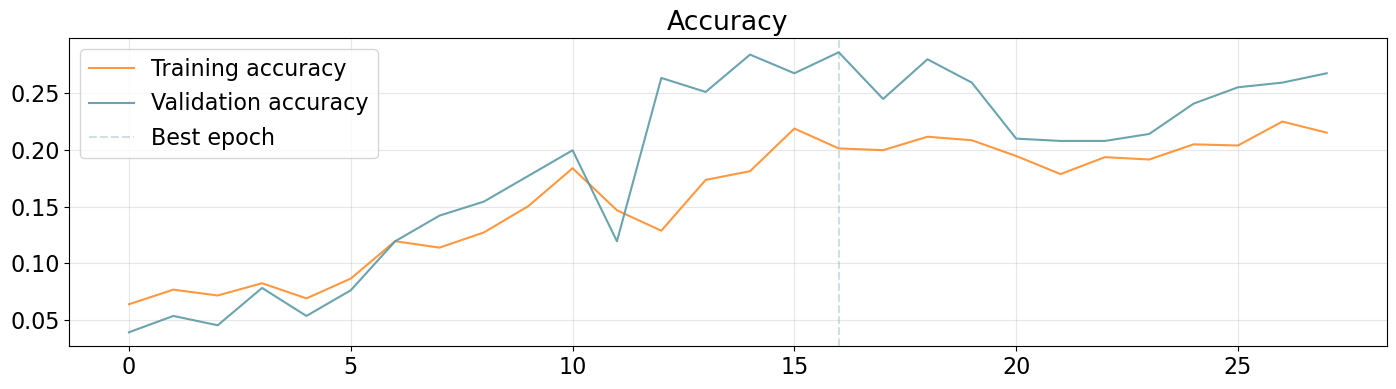

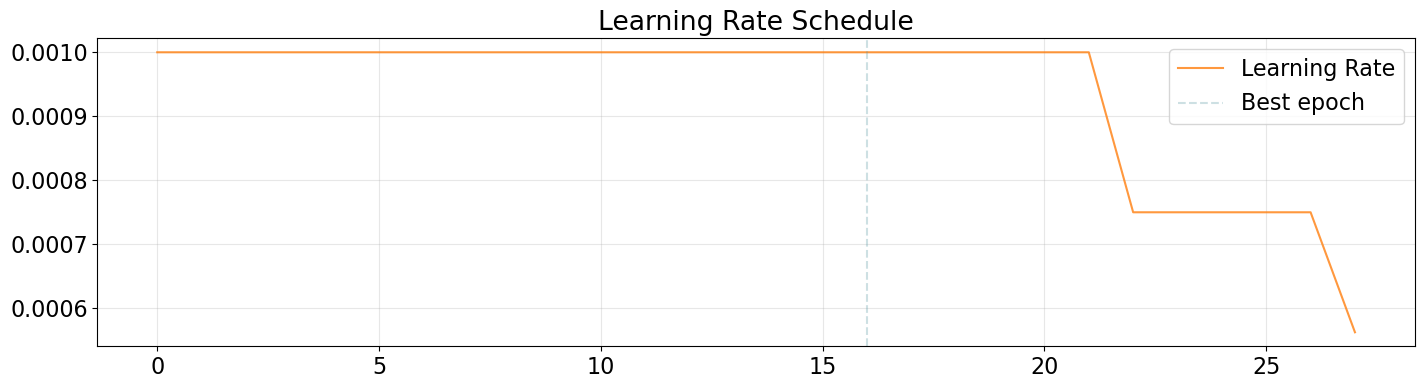

16/16 [==============================] - 0s 6ms/step
Accuracy: 0.286
Precision: 0.3371
Recall: 0.3272
F1: 0.2856


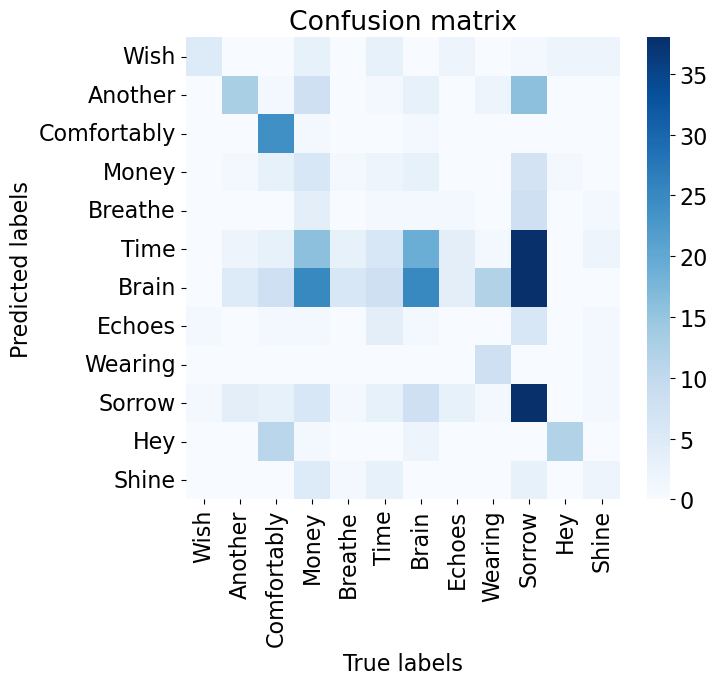

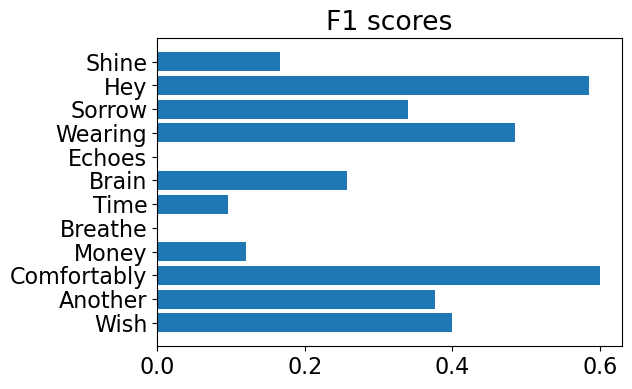

In [82]:
plot_history(history)

# Predict the test set with the LSTM
predictions = model.predict(X_test)

plot_statistics(predictions)